In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-306a879839c2>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


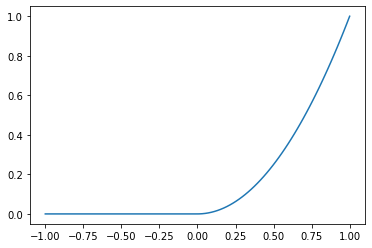

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)**2

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [27]:
from typing import *

class DetectorLoss(nn.Module):
    def __init__(self, target_budget: Union[Tensor, float], budget_smoothing:Union[Tensor, float]=10, cost_coef: Optional[Union[Tensor, float]] = None):
        super().__init__()
        self.target_budget, self.budget_smoothing, self.cost_coef = target_budget, budget_smoothing, cost_coef
        self.sub_losses: Dict[str, Tensor] = {}  # Store subcomponents in dict for telemetry
            
    def _get_budget_coef(self, cost: Tensor) -> Tensor:
        r'''Switch-on near target budget, plus linear increase above budget'''
        d = (cost-self.target_budget)
        return (2*torch.sigmoid(self.budget_smoothing*d/self.target_budget)) + (F.relu(d)/self.target_budget)

    def _compute_cost_coef(self, cost: Tensor, inference: Tensor) -> None:
        self.cost_coef = inference.detach() / cost.detach()
        print(f"Automatically setting cost coefficient to {self.cost_coef}")

    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        true_x0 = volume.get_rad_cube()
        inference = torch.mean((pred_x0 - true_x0).pow(2) / pred_weight)
        self.sub_losses["error"] = inference
        cost = volume.get_cost()
        if self.cost_coef is None:
            self._compute_cost_coef(cost, inference)
        self.sub_losses["cost"] = self._get_budget_coef(cost) * self.cost_coef * cost
        print(f'Loss details: cost {cost:.3E}, cost coef {self.cost_coef:.3E}, budget coef {self._get_budget_coef(cost):.3E}. error loss {self.sub_losses["error"]:.3E}, cost loss {self.sub_losses["cost"]:.3E}')
        return self.sub_losses["error"] + self.sub_losses["cost"]

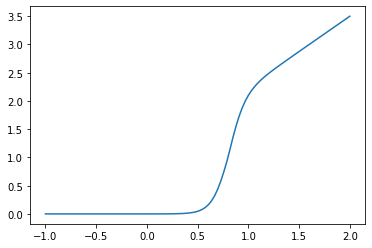

In [28]:
def area_coef(x:Tensor, targ:float) -> Tensor:
    return (2*torch.sigmoid(10*(x-targ)/targ)) + F.relu(x-targ)/targ

x = torch.linspace(-1, 2)
plt.plot(x, area_coef(x, 0.8))

In [29]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [30]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]),

In [31]:
volume.get_cost()

tensor(8., grad_fn=<AddBackward0>)

In [32]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=5e3),
                             loss_func=DetectorLoss(target_budget=0.8, cost_coef=None))  # Loss is precision + cost_coef*detector cost, balance coef as required or leave as None to automatically balance on first batch

In [33]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [34]:
passives = PassiveYielder([arb_rad_length])

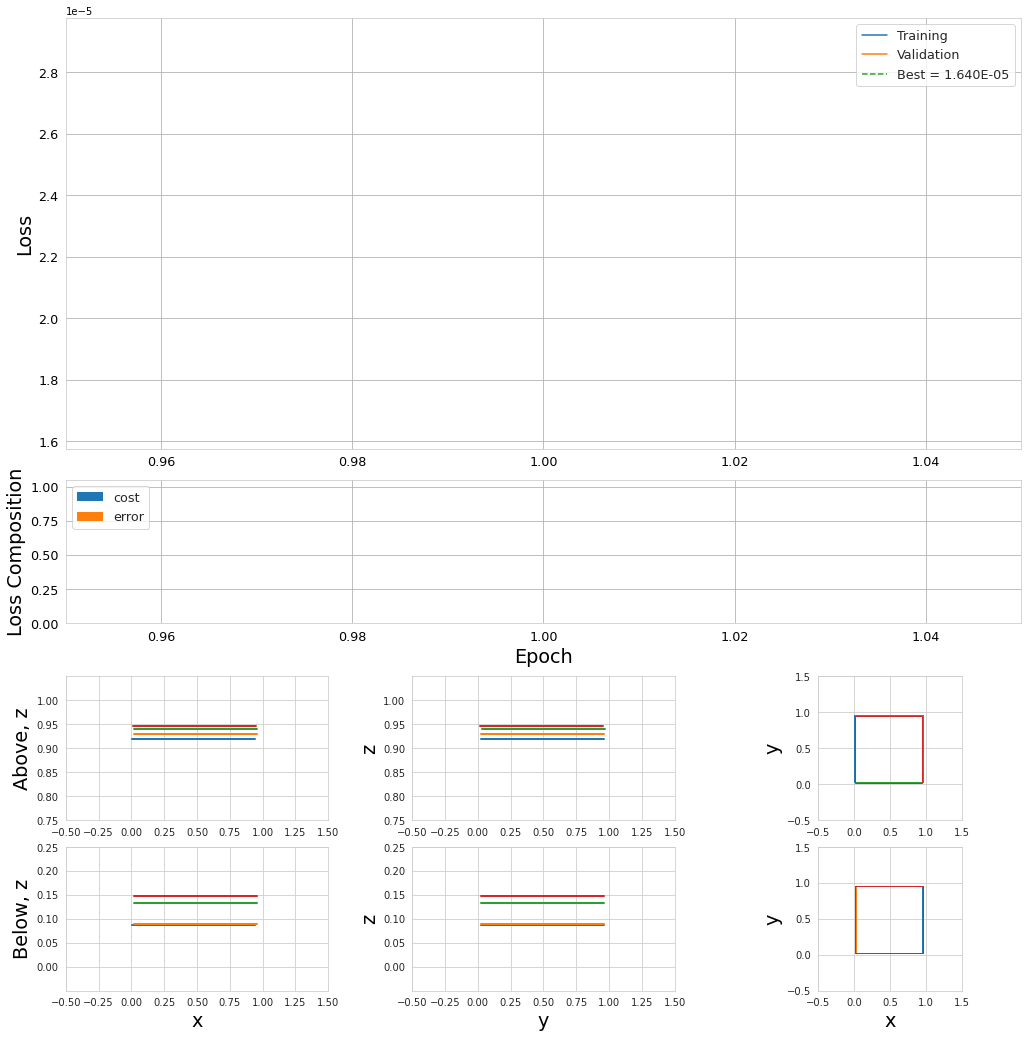

Automatically setting cost coefficient to 3.034284077330085e-07
Loss details: cost 8.000E+00, cost coef 3.034E-07, budget coef 1.100E+01. error loss 2.427E-06, cost loss 2.670E-05
Loss details: cost 6.171E+00, cost coef 3.034E-07, budget coef 8.713E+00. error loss 8.184E-08, cost loss 1.631E-05


/home/centos/volume/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/centos/volume/mode_muon_tomography/tomopt/optimisation/wrapper/volume_wrapper.py", line 298, in fit
    self._fit_epoch()
  File "/home/centos/volume/mode_muon_tomography/tomopt/optimisation/wrapper/volume_wrapper.py", line 239, in _fit_epoch
    run_epoch(self.fit_params.trn_passives)
  File "/home/centos/volume/mode_muon_tomography/tomopt/optimisation/wrapper/volume_wrapper.py", line 231, in run_epoch
    self._scan_volumes(passives)
  File "/home/centos/volume/mode_muon_tomography/tomopt/optimisation/wrapper/volume_wrapper.py", line 200, in _scan_volumes
    self._scan_volume()
  File "/home/centos/volume/mode_muon_tomography/tomopt/optimisation/wrapper/volume_wrapper.py", line 154, in _scan_volume
    pred, wgt = inferer.pred_x0(inc_default=False)
  File "/home/centos/volume/mode_muon_tomography/tomopt/inference/rad_length.py", line 221, in pred_x0
    pred, weight = self.average_preds(x0_dtheta=x0_dtheta, x0_dtheta_unc=x0_dtheta_unc

TypeError: object of type 'NoneType' has no len()

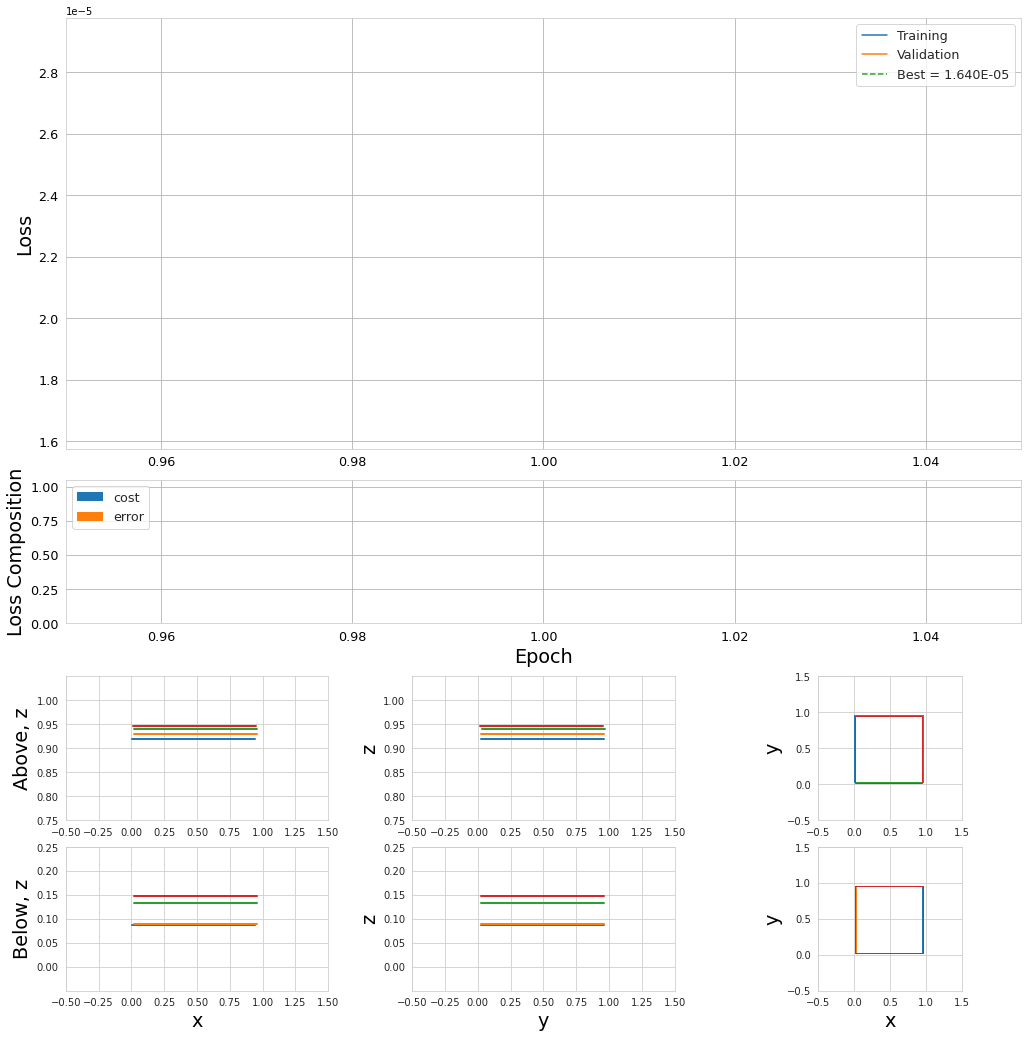

In [35]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[PanelMetricLogger()])

In [ ]:
for p in volume.parameters(): print(p)